## Compare the linear model coefficients for plate 1 and 2

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
# Set file paths
coef_dir <- file.path("..", "linear_model", "results")
plate_1_file <- file.path(coef_dir, "Plate1", "linear_model_all_cp_features.tsv")
plate_2_file <- file.path(coef_dir, "Plate2", "linear_model_all_cp_features.tsv")

output_file <- file.path("figures", "plate1_vs_2_coefficients.png")

In [3]:
# Load coefficients
plate_1_df <- readr::read_tsv(
    plate_1_file, col_types=readr::cols(.default = "d", feature="c")
)

# Recode column names
colnames(plate_1_df)[seq(2, ncol(plate_1_df))] <- (
    paste0(colnames(plate_1_df)[seq(2, ncol(plate_1_df))], "_plate1")
)

plate_2_df <- readr::read_tsv(
    plate_2_file, col_types=readr::cols(.default = "d", feature="c")
)

colnames(plate_2_df)[seq(2, ncol(plate_2_df))] <- (
    paste0(colnames(plate_2_df)[seq(2, ncol(plate_2_df))], "_plate2")
)

plate_df <- plate_1_df %>%
    dplyr::full_join(plate_2_df, by = "feature") %>%
    dplyr::mutate(mean_r2 = (r2_score_plate1 + r2_score_plate2) / 2) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

# Clean channel for visualization
plate_df$channel_cleaned <-
    dplyr::recode(
        plate_df$channel_cleaned,
        "DAPI" = "nuclei",
        "RFP" = "actin",
        "GFP" = "ER",
        .default = "other",
        .missing="other"
    )

print(dim(plate_df))
head(plate_df, 3)

Warning message:
“Expected 6 pieces. Additional pieces discarded in 468 rows [236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 730 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


[1] 1198   17


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,r2_score_plate1,cell_count_coef_plate1,Null_coef_plate1,WT_coef_plate1,r2_score_plate2,cell_count_coef_plate2,Null_coef_plate2,WT_coef_plate2,mean_r2,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cytoplasm_Number_Object_Number,Cytoplasm,Number,Object,Number,NA,NA,0.3191403,0.02774250,-0.007550375,0.007550375,0.1298923,0.02362698,0.01030461,-0.01030461,0.2245163,other
Cytoplasm_AreaShape_Area,Cytoplasm,AreaShape,Area,NA,NA,NA,0.3104025,-0.01530784,-0.323817631,0.323817631,0.2277815,-0.01307942,-0.33243517,0.33243517,0.2690920,other
Cytoplasm_AreaShape_BoundingBoxArea,Cytoplasm,AreaShape,BoundingBoxArea,NA,NA,NA,0.3832428,-0.02171712,-0.245113643,0.245113643,0.1711883,-0.01613497,-0.21808162,0.21808162,0.2772156,other


In [4]:
cor_result <- cor.test(
    plate_df$Null_coef_plate1,
    plate_df$Null_coef_plate2,
    method = "pearson"
)
cor_result


	Pearson's product-moment correlation

data:  plate_df$Null_coef_plate1 and plate_df$Null_coef_plate2
t = 15.535, df = 1196, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3615210 0.4558258
sample estimates:
      cor 
0.4097677 


In [5]:
plot_title <- paste0(
    "NF1 genotype differences are correlated across plates\n(r = ",
    round(cor_result$estimate, 2),
    ", p = ",
    format(cor_result$p.value, scientific = TRUE, digits = 2),
    ")"
)

[1] "NF1 genotype differences are correlated across plates\n(r = 0.41, p = 1e-49)"

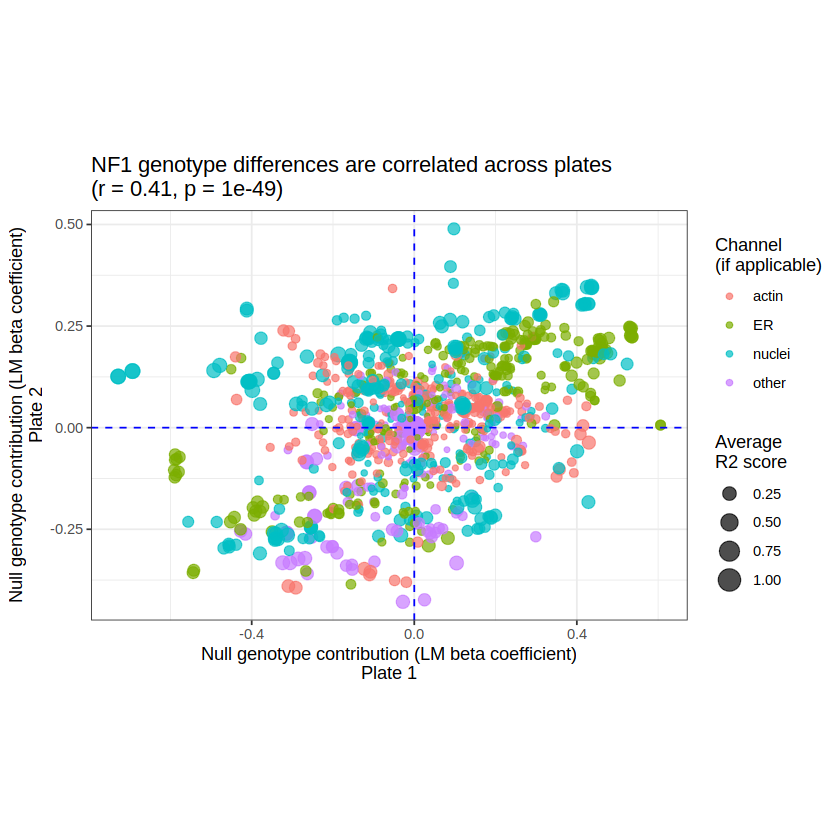

In [6]:
coef_fig <- (
    ggplot(plate_df, aes(x = Null_coef_plate1, y = Null_coef_plate2))
    + geom_point(aes(size = mean_r2, color = channel_cleaned), alpha = 0.7)
    + theme_bw()
    + coord_fixed()
    + geom_vline(xintercept=0, linetype="dashed", color="blue")
    + geom_hline(yintercept=0, linetype="dashed", color="blue")
    + ylab("Null genotype contribution (LM beta coefficient)\nPlate 2")
    + xlab("Null genotype contribution (LM beta coefficient)\nPlate 1")
    + ggtitle(plot_title)
    + guides(
        color = guide_legend(title = "Channel\n(if applicable)", order = 1),
        size = guide_legend(title = "Average\nR2 score")
    )
)

# Output figure
ggsave(output_file, coef_fig, dpi = 500, height = 7, width = 8)

coef_fig